# Dependence

In [364]:
import torch
import torch.nn as nn
import torch.autograd as autograd

import numpy as np 

from pyDOE import lhs

import matplotlib.pyplot as plt
import matplotlib.tri as mtri

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameter

In [365]:
steps = 10000
layers = np.array([2,32,64,32,2])
lr = 0.001

Nf = 10000

# Auxiliary Functions


In [366]:
def Plot(V,tris,U):
    _,ax=plt.subplots()
    ax.tripcolor(V[:,0],V[:,1],tris,U,cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('U')
    plt.show()

# Build initial physical mesh

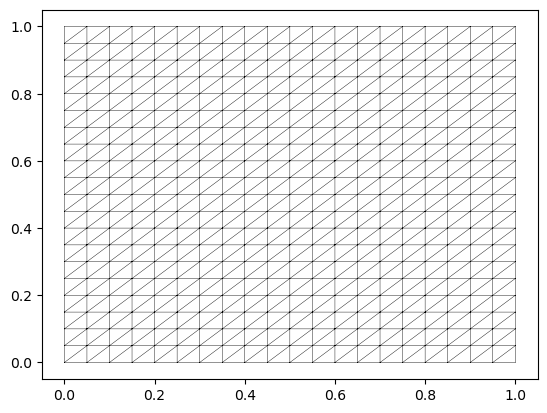

In [367]:
m_rows = 20
m_cols = 20

x = torch.linspace(0, 1, m_cols + 1)
y = torch.linspace(0, 1, m_rows + 1)
x = x.repeat(m_rows + 1)
y = y.repeat_interleave(m_cols + 1)
V = torch.stack([x,y],dim=1)

tris = []

for i in range(m_cols):
   for j in range(m_rows):
       tris.append([j * (m_cols + 1) + i, j * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i + 1])
       tris.append([j * (m_cols + 1) + i, (j + 1) * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i])
        
tris = torch.tensor(tris, dtype=torch.short)

left_boundarys = V[(V[:,0]==0.0)]
bottom_boundarys = V[(V[:,1]==0.0)]
top_boundarys = V[(V[:,1]==1.0)]
right_boundarys = V[(V[:,0]==1.0)]

plt.triplot(x,y,tris,'k-',linewidth=0.3)
plt.show()

# Training Data

In [368]:
left_V = V[(V[:,0]==0.0)]
right_V = V[(V[:,0]==1.0)]
bottom_V = V[(V[:,1]==0.0)]
top_V = V[(V[:,1]==1.0)]

PDE_V = V[0] + (V[-1]-V[0])*lhs(2,Nf)

V = V.to(device)
left_V = left_V.float().to(device)
right_V = right_V.float().to(device)
bottom_V = bottom_V.float().to(device)
top_V = top_V.float().to(device)
PDE_V = PDE_V.float().to(device)

C:\Users\13162\AppData\Local\Temp\ipykernel_7268\3678288465.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  PDE_V = V[0] + (V[-1]-V[0])*lhs(2,Nf)


# Functions

In [369]:
def U(V):
    return torch.tanh(-30*(V[:,1]-0.5-0.25*torch.sin(2*torch.pi*V[:,0])))

def U_x_y(V):
    U_x = (1-U(V)**2)*(15*torch.pi*torch.cos(2*torch.pi*V[:,0]))
    U_y = (1-U(V)**2)*(-30)
    return torch.stack([U_x,U_y],dim=1)

def Metric(V):
    u_x_y = U_x_y(V)
    return torch.sqrt(torch.linalg.norm(u_x_y,dim=1)**2 + 1)

# M = Metric(V)
# Plot(V.detach().cpu(),tris.detach().cpu(),M.detach().cpu())

# Neural Network generates initial logical mesh

$$
\begin{cases}
-\nabla \cdot (\nabla \xi) = 0, \\
\xi|_{\partial \Omega} = \xi_b,
\end{cases}
$$


In [370]:
class FCN1(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers 
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.loss_function2 = nn.L1Loss(reduction ='sum')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)   

    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(self.layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)
        a = self.linears[-1](a)
        return a    
    
    def loss_BC(self,left_V,right_V,bottom_V,top_V):
        return self.loss_function2(self.forward(left_V),left_V) + \
               self.loss_function2(self.forward(right_V),right_V) + \
               self.loss_function2(self.forward(bottom_V),bottom_V) + \
               self.loss_function2(self.forward(top_V),top_V)
              
    def loss_PDE(self,PDE_V):
        g = PDE_V.clone()
        g.requires_grad = True
        xi_eta = self.forward(g)
        xi = xi_eta[:,0].unsqueeze(1)
        eta = xi_eta[:,1].unsqueeze(1)
        xi_x_y = autograd.grad(xi,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        xi_xx_yy = autograd.grad(xi_x_y,g,torch.ones(g.shape).to(device),create_graph=True)[0]
        eta_x_y = autograd.grad(eta,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        eta_xx_yy = autograd.grad(eta_x_y,g,torch.ones(g.shape).to(device),create_graph=True)[0]  
        return self.loss_function(xi_xx_yy[:,[0]]+xi_xx_yy[:,[1]],torch.zeros(g.shape[0],1).to(device)) + \
                self.loss_function(eta_xx_yy[:,[0]]+eta_xx_yy[:,[1]],torch.zeros(g.shape[0],1).to(device))

    def loss(self,left_V,right_V,bottom_V,top_V,PDE_V):      
        return self.loss_PDE(PDE_V) + self.loss_BC(left_V,right_V,bottom_V,top_V)

# Generate initial logic mesh

0 58.61868
1 46.695385
2 36.904526
3 29.199049
4 23.167143
5 21.834164
6 19.780582
7 16.504559
8 13.174001
9 15.8709545
10 17.748491
11 16.892456
12 13.932503
13 9.737753
14 6.8448844
15 7.5310163
16 9.003648
17 9.186711
18 9.693056
19 10.144472
20 9.737022
21 8.329083
22 5.989673
23 4.3940225
24 4.9328446
25 5.4658
26 5.8219943
27 5.576185
28 4.427878
29 3.3705351
30 3.569832
31 3.9928465
32 4.178031
33 4.026437
34 3.1618814
35 2.518402
36 2.9384904
37 3.5496585
38 3.5553555
39 3.055881
40 2.7089894
41 2.8792195
42 2.9315994
43 2.6569808
44 2.5179071
45 2.5169897
46 2.7303672
47 2.7775614
48 2.5232413
49 2.4082031
50 2.451245
51 2.4136672
52 2.4089777
53 2.2514737
54 2.319681
55 2.3528574
56 2.3039432
57 2.1798155
58 2.0735335
59 2.184031
60 2.2855928
61 2.1804893
62 2.1707206
63 2.1384199
64 2.1578164
65 2.176553
66 2.014161
67 2.0239358
68 2.052703
69 1.9826931
70 1.962311
71 2.137703
72 1.9625052
73 1.9254682
74 2.0074348
75 1.8650017
76 2.046727
77 1.9317882
78 2.033202
79 1.83303

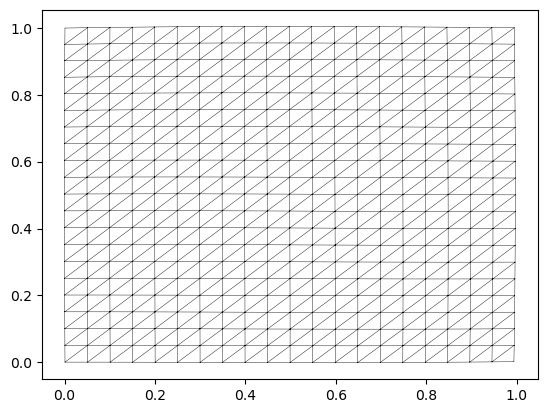

In [371]:
xi_0 = FCN1(layers).to(device)
optimizer = torch.optim.Adam(xi_0.parameters(),lr=lr,amsgrad=False)

for i in range(steps):
    loss = xi_0.loss(left_V,right_V,bottom_V,top_V,PDE_V)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(i,loss.detach().cpu().numpy())
    
V_xi_0 = xi_0(V)
V_xi_0_cpu = xi_0(V).detach().cpu()
plt.triplot(V_xi_0_cpu[:,0],V_xi_0_cpu[:,1],tris.detach().cpu(),'k-',linewidth=0.3)


# Neural Network generates harmonic maps

$$
\begin{cases}
-\nabla \cdot (\frac{1}{M(x)}\nabla \xi) = 0, \\
\xi|_{\partial \Omega} = \xi_b,
\end{cases}\\
$$

$$
M(x) = \sqrt{1+0.1||\nabla u||_2^2}
$$


In [372]:
class FCN2(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers 
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.loss_function2 = nn.L1Loss(reduction ='sum')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)   

    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(self.layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)
        a = self.linears[-1](a)
        return a    
    
    def loss_BC(self,left_V,right_V,bottom_V,top_V):
        return self.loss_function2(self.forward(left_V),left_V) + \
               self.loss_function2(self.forward(right_V),right_V) + \
               self.loss_function2(self.forward(bottom_V),bottom_V) + \
               self.loss_function2(self.forward(top_V),top_V)
    
    def loss_PDE(self,PDE_V):
        g = PDE_V.clone()
        g.requires_grad = True
        xi_eta = self.forward(g)
        xi = xi_eta[:,0].unsqueeze(1)
        eta = xi_eta[:,1].unsqueeze(1)
        M = Metric(g).unsqueeze(1)
        M_xi_x_y = autograd.grad(xi,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0] / M
        M_eta_x_y = autograd.grad(eta,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0] / M
        M_xi_xx_yy = autograd.grad(M_xi_x_y,g,torch.ones(g.shape).to(device),create_graph=True)[0]
        M_eta_xx_yy = autograd.grad(M_eta_x_y,g,torch.ones(g.shape).to(device),create_graph=True)[0] 
        return self.loss_function(M_xi_xx_yy[:,[0]]+M_xi_xx_yy[:,[1]],torch.zeros(g.shape[0],1).to(device)) + \
                self.loss_function(M_eta_xx_yy[:,[0]]+M_eta_xx_yy[:,[1]],torch.zeros(g.shape[0],1).to(device))

    def loss(self,left_V,right_V,bottom_V,top_V,PDE_V):      
        return self.loss_PDE(PDE_V) + self.loss_BC(left_V,right_V,bottom_V,top_V)
    

# Generate harmonic maps

0 104.742645
1 85.401634
2 73.44738
3 67.56802
4 65.206726
5 64.660576
6 64.05849
7 62.376602
8 59.456577
9 55.72815
10 51.803608
11 48.214912
12 45.370155
13 43.497692
14 42.74344
15 42.42868
16 42.19864
17 41.89203
18 41.510494
19 41.17289
20 41.02806
21 40.995255
22 41.04956
23 41.13722
24 41.169907
25 41.083126
26 40.865356
27 40.52951
28 40.14984
29 39.841393
30 39.622272
31 39.501457
32 39.50363
33 39.576927
34 39.651207
35 39.663715
36 39.6187
37 39.564106
38 39.464523
39 39.361217
40 39.265816
41 39.189972
42 39.12802
43 39.070206
44 38.9976
45 38.911045
46 38.83902
47 38.7901
48 38.79352
49 38.816208
50 38.82591
51 38.810707
52 38.77108
53 38.7078
54 38.66262
55 38.628582
56 38.62066
57 38.634136
58 38.656387
59 38.66451
60 38.63458
61 38.59685
62 38.58299
63 38.568226
64 38.55088
65 38.54416
66 38.51652
67 38.479885
68 38.463093
69 38.474304
70 38.458035
71 38.448647
72 38.4455
73 38.42603
74 38.42445
75 38.43471
76 38.408764
77 38.391907
78 38.39224
79 38.380745
80 38.36204


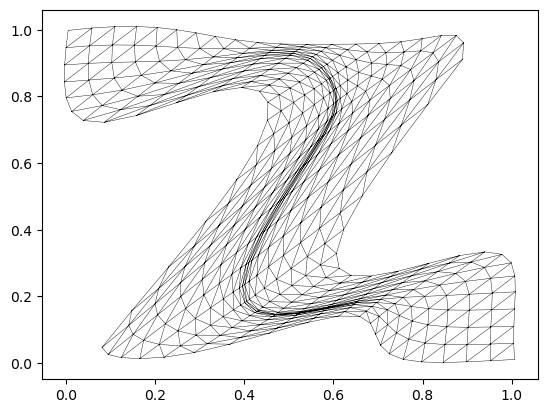

In [373]:
xi_new = FCN2(layers).to(device)
optimizer = torch.optim.Adam(xi_new.parameters(),lr=lr,amsgrad=False)

for i in range(steps):
    loss = xi_new.loss(left_V,right_V,bottom_V,top_V,PDE_V)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(i,loss.detach().cpu().numpy())
    
V.requires_grad = True
V_xi_new = xi_new(V)
V_xi_new_cpu = V_xi_new.detach().cpu()
plt.triplot(V_xi_new_cpu[:,0],V_xi_new_cpu[:,1],tris.detach().cpu(),'k-',linewidth=0.3)

# Update physical mesh

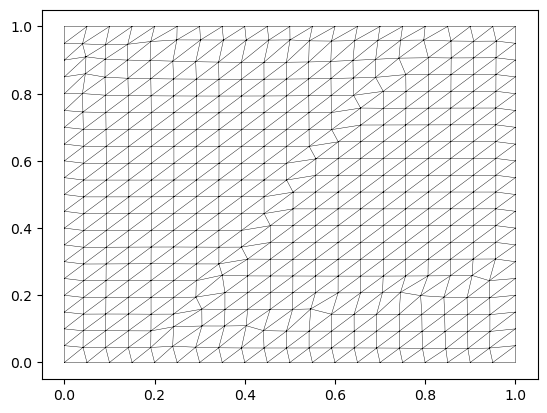

In [374]:
xi_x_y = autograd.grad(V_xi_new[:,0].unsqueeze(1),V,torch.ones([V.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
eta_x_y = autograd.grad(V_xi_new[:,1].unsqueeze(1),V,torch.ones([V.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
xi_x,xi_y,eta_x,eta_y = xi_x_y[:,[0]],xi_x_y[:,[1]],eta_x_y[:,[0]],eta_x_y[:,[1]]
delta_V_xi = V_xi_0 - V_xi_new
delta_V_xi_x = delta_V_xi[:,0].unsqueeze(1)
delta_V_xi_y = delta_V_xi[:,1].unsqueeze(1)
delta_V_x = (1/(xi_x*eta_y-xi_y*eta_x)*(eta_y*delta_V_xi_x-xi_y*delta_V_xi_y)).squeeze()
delta_V_y = (1/(xi_x*eta_y-xi_y*eta_x)*(-eta_x*delta_V_xi_x+xi_x*delta_V_xi_y)).squeeze()
delta_V = torch.stack([delta_V_x,delta_V_y],dim=1)
delta_V = delta_V / torch.linalg.norm(delta_V,dim=1).unsqueeze(1) * 0.01
delta_V[V[:,0]==0.0] = 0.0
delta_V[V[:,0]==1.0] = 0.0
delta_V[V[:,1]==0.0] = 0.0
delta_V[V[:,1]==1.0] = 0.0

new_V = (V + delta_V).detach().cpu()

plt.triplot(new_V[:,0],new_V[:,1],tris.detach().cpu(),'k-',linewidth=0.3)
plt.show()